In [86]:
#import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install opencv-python

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.
'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.
'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


Importing Required Libraries

In [87]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


Importing Data from 'Train' folder 

In [88]:
# Importing data from the 'Train' Folder
data = r'Train'
# Creating empty list to store filenames
files = []
# Iterating through the data and storing the filenames in the files list
for _, _, files in os.walk(data):
    break
# Printing the total number of images currently being used to train and test the models below
print(f'Total number of files: {len(files)}')


Total number of files: 971


Classifying the images based on the labels in the filename

Something to note, I originally created the array of just size 1 that stored the value of each label in that single spot as 0,1,2 but it resulted in accuracy ratings never changing between epochs and being lower after trying different techniques this is the current attempt that is having the best results, currently values are stored in a numpy array of size 3 where the first value being 1 represents a lower class, the second being 1 represents middle and the third being 1 represents upper class.

What Y looks like
Y = ([[1. 0. 0.], [0. 1. 0.], [0. 0. 1.]])

In [89]:

# Creating a numpy array of zeros the length of the dataset with a size of shape of 3
Y = np.zeros((len(files), 3))

# Loop through the list of filenames
for i, f in enumerate(files):

    # If the filename contains 'lower' set the first value of the array to 1
    if 'lower' in f:
        Y[i, 0] = 1  
    # If the filename contains 'middle' set the second value of the array to 1
    elif 'middle' in f:
        Y[i, 1] = 1  
    # If the filename contains 'upper' set the third value of the array to 1
    elif 'upper' in f:
        Y[i, 2] = 1  

#Create the path to each file 
files = [os.path.join(data, f) for f in files]

#Example showing the path to the file and the coorisponding label showing what we have classified as middle in the numpy array.
print(f'File location: {files[1]}\n Classified as: {Y[1]}')

File location: Train\img1005_middle.jpg
 Classified as: [0. 1. 0.]


# Creating a Sequential model 
This runs for multiple image sizes to determine the Evaluation scores based on image size

In [90]:
# List of image sizes
image_size = [(16, 16), (32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]

# Epoch count, currently anything over 5 epochs does not result in any change in the accuracy rating
epochs = 5

# Creating a list to store the image sizes and accuracy ratings for the Sequential Model
conv_accuracy_results = []

# Looping through each image size
for size in image_size:

    # Creating a list of each images numerical values
    X = []

    for file in files:
        img = cv2.imread(file) 
        # Resizing the image based on the specific tuple in image_sizes
        img = cv2.resize(img, size) 
        X.append(img)

    # Scaling the image data down to values between 0 and 1
    X = np.array(X, dtype='float32') / 255

    # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

    # Creating a Sequential Convolution Neural Network model with 2 layers
    model = models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (size[0], size[1], 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = (size[0], size[1], 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # Dense layer of size 3 to match the input size of the numpy array Y
    layers.Dense(3, activation='softmax')
    ])

    # Compiling the model utilizing the adam optimizer and categorical crossentropy 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
    model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.2)
    
    # Predicting the outputs of the test data using the model
    y_pred = model.predict(X_test)

    # Converting the One-Hot labels into class indices so they can be used to for evaluation
    Y_test_classes = np.argmax(Y_test, axis=1)
    Y_pred_classes = np.argmax(y_pred, axis = 1)

    # Calculating Evaluation Metrics
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
    recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
    f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
    classification_rep = classification_report(Y_test_classes,Y_pred_classes)
    
    # Appending all the evaluation metrics into the conv_accuracy_results list
    conv_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

    # Printing the Classification Report for that image size
    print(f'Image Size: {size}')
    print(classification_rep)

    

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4185 - loss: 1.0269 - val_accuracy: 0.4231 - val_loss: 1.0119
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4520 - loss: 0.9836 - val_accuracy: 0.4487 - val_loss: 1.0034
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4478 - loss: 1.0001 - val_accuracy: 0.4551 - val_loss: 0.9967
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4715 - loss: 0.9710 - val_accuracy: 0.4423 - val_loss: 0.9990
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4590 - loss: 0.9848 - val_accuracy: 0.4551 - val_loss: 0.9947
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Image Size: (16, 16)
              precision    recall  f1-score   support

           0       0.62      0.22      0.33        90
           1       0.39      0.86      0.53        73
           2       0.00      0.00      0.00        32

    accuracy                           0.43       195
   macro avg       0.34      0.36      0.29       195

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4170 - loss: 1.0378 - val_accuracy: 0.4231 - val_loss: 1.0108
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4234 - loss: 1.0044 - val_accuracy: 0.4231 - val_loss: 1.0031
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4308 - loss: 0.9989 - val_accuracy: 0.4615 - val_loss: 0.9953
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4954 - loss: 0.9949 - val_accuracy: 0.4231 - val_loss: 1.0015
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4458 - loss: 0.9981 - val_accuracy: 0.4808 - val_loss: 0.9908
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.43      0.13      0.20        90
           1       0.38      0.86      0.53        73
           2       0.00      0.00      0.00        32

    accuracy                           0.38       195
   macro avg       0.27      0.33      0.24       1

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3882 - loss: 1.3072 - val_accuracy: 0.4423 - val_loss: 1.0333
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4541 - loss: 1.0213 - val_accuracy: 0.4231 - val_loss: 1.0070
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4656 - loss: 1.0012 - val_accuracy: 0.4103 - val_loss: 0.9974
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4777 - loss: 0.9947 - val_accuracy: 0.4808 - val_loss: 0.9936
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6009 - loss: 0.9293 - val_accuracy: 0.4808 - val_loss: 0.9879
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        90
           1       0.46      0.73      0.56        73
           2       0.00      0.00      0.00        32

    accuracy                           0.50       195
   macro avg       0.34      0.41      0.36      

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.3902 - loss: 3.4881 - val_accuracy: 0.4423 - val_loss: 1.1069
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.4371 - loss: 1.0975 - val_accuracy: 0.4423 - val_loss: 1.0065
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.4666 - loss: 0.9982 - val_accuracy: 0.4744 - val_loss: 1.0101
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5445 - loss: 0.9816 - val_accuracy: 0.4744 - val_loss: 0.9948
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.6495 - loss: 0.8612 - val_accuracy: 0.4231 - val_loss: 1.0173
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.49      0.84      0.62        90
           1       0.45      0.25      0.32        73
           2       0.00      0.00      0.00        32

    accuracy                           0.48       195
   macro avg       0.31      0.36      0.3

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 696ms/step - accuracy: 0.4066 - loss: 4.6087 - val_accuracy: 0.4423 - val_loss: 1.0710
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.4433 - loss: 1.0947 - val_accuracy: 0.5192 - val_loss: 1.0189
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.4879 - loss: 1.0042 - val_accuracy: 0.4231 - val_loss: 1.0165
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 662ms/step - accuracy: 0.5214 - loss: 0.9634 - val_accuracy: 0.4423 - val_loss: 1.0058
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 653ms/step - accuracy: 0.6267 - loss: 0.8428 - val_accuracy: 0.5064 - val_loss: 0.9716
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.52      0.30      0.38        90
           1       0.41      0.79      0.54        73
           2       0.00      0.00      0.00        32

    accuracy                           0.44       195
   macro avg       0.31      0.36      0.3

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3478 - loss: 29.6100 - val_accuracy: 0.4423 - val_loss: 1.8424
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4461 - loss: 1.3634 - val_accuracy: 0.4231 - val_loss: 1.0775
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4786 - loss: 0.9860 - val_accuracy: 0.4744 - val_loss: 1.0301
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7982 - loss: 0.6291 - val_accuracy: 0.4487 - val_loss: 1.0798
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9499 - loss: 0.2285 - val_accuracy: 0.4231 - val_loss: 1.2622
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.46      0.41      0.44        90
           1       0.40      0.53      0.46        73
           2       0.29      0.16      0.20        32

    accuracy                           0.42       195
   macro avg       0.38      0.37      0

# Graphing the Accuracy Ratings
Something to note and look at later, I have ran this multiple times and each output is significantly different, sometimes prefering a smaller image size and sometimes prefering larger.

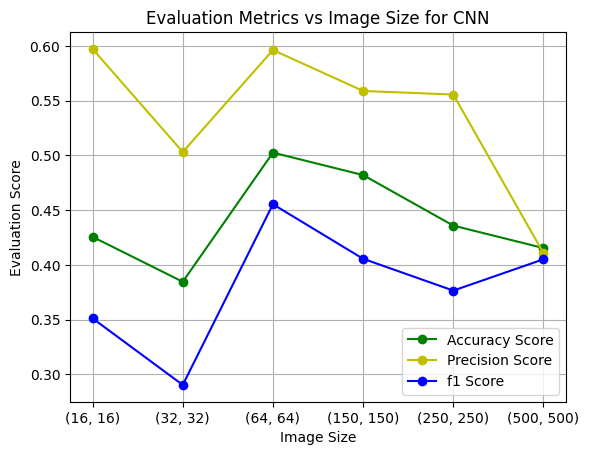

In [95]:
# Creating variables for each item in conv_accuracy_results
sizes, acc, prec, recall, f1, classrep = zip(*conv_accuracy_results)

# Converting the image sizes into a string so they can be used for the X axis
sizes = [str(size) for size in sizes]

# Plot showing the Evaluation Metrics vs Image Size
plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
# Not using recall as it is identical to the accuracy rating when tested currently
#plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
plt.title('Evaluation Metrics vs Image Size for CNN')
plt.xlabel('Image Size')
plt.ylabel('Evaluation Score')
plt.legend()
plt.grid()
plt.show()

# Creating the ResNet Model
This runs for multiple image sizes to determine the Evaluation Scores based on image size

In [93]:
# List of image sizes
image_size = [(32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]

# Epoch count, currently set to 5
epochs = 5

# Creating a list to store the image sizes and accuracy ratings for the ResNet model
resNet_accuracy_results = []

# Looping through each image size
for size in image_size:
    # Creating a list of each images numerical values
    X = []

    for file in files:
        img = cv2.imread(file) 
        # Resizing the image based on the specific tuple in image_sizes
        img = cv2.resize(img, (size[0], size[1]))  
        X.append(img)

    # Scaling the image data down to values between 0 and 1
    X = np.array(X, dtype='float32') / 255.0
    
    # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

    # Creating a ResNet50V2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
    resbase = applications.ResNet50V2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
    # Allows only the new layers to be trainable
    resbase.trainable = False
    # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
    # Currently attempting with only 1 extra layer
    resModel = models.Sequential([
        # Calling the resbase which was assigned to the ResNet model created before
        resbase,

        # Adding our extra layers to be trained
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation= 'relu', input_shape = (size[0], size[1], 3)),
        
        # Dense layer of size 3 to match the input size of the numpy array Y
        layers.Dense(3, activation='softmax')
    ])
    
    # Compiling the model utilizing the adam optimizer and categorical crossentropy 
    resModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
    resModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

    # Predicting the outputs of the test data using the model
    y_pred = resModel.predict(X_test)
    
    # Converting the One-Hot labels into class indices so they can be used to for evaluation
    Y_test_classes = np.argmax(Y_test, axis=1)
    Y_pred_classes = np.argmax(y_pred, axis = 1)
    
    # Calculating Evaluation Metrics
    accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
    precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
    classification_rep = classification_report(Y_test_classes,Y_pred_classes)

     # Appending all the evaluation metrics into the resNet_accuracy_results list
    resNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

    # Printing the Classification Report for that image size
    print(f'Image Size: {size}')
    print(classification_rep)

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.4530 - loss: 1.0426 - val_accuracy: 0.4423 - val_loss: 1.0062
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5904 - loss: 0.9227 - val_accuracy: 0.4936 - val_loss: 0.9715
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6615 - loss: 0.8272 - val_accuracy: 0.5064 - val_loss: 0.9643
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6942 - loss: 0.7797 - val_accuracy: 0.5385 - val_loss: 0.9725
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7269 - loss: 0.7184 - val_accuracy: 0.5385 - val_loss: 0.9669
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.47      0.48      0.48        90
           1       0.37      0.52      0.43        73
           2       0.00      0.00      0.00        32

    accuracy                           0.42       195
   macro avg       0.28      0.33      0.30    

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/5


c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.4254 - loss: 1.5609 - val_accuracy: 0.4295 - val_loss: 1.4521
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.6156 - loss: 0.8602 - val_accuracy: 0.4551 - val_loss: 1.1917
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.7830 - loss: 0.5224 - val_accuracy: 0.5321 - val_loss: 1.2108
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.8865 - loss: 0.3622 - val_accuracy: 0.5064 - val_loss: 1.2453
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9280 - loss: 0.2777 - val_accuracy: 0.5256 - val_loss: 1.2902
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        90
           1       0.38      0.52      0.44        73
           2       0.33      0.12      0.18        32

    accuracy                           0.45       195
   macro avg       0.42      0.39      0.38

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 887ms/step - accuracy: 0.4107 - loss: 1.5645 - val_accuracy: 0.4679 - val_loss: 1.2832
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.5449 - loss: 0.9369 - val_accuracy: 0.5641 - val_loss: 1.0469
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 753ms/step - accuracy: 0.6859 - loss: 0.7404 - val_accuracy: 0.5449 - val_loss: 0.9851
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 750ms/step - accuracy: 0.8029 - loss: 0.5229 - val_accuracy: 0.5897 - val_loss: 1.0073
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 780ms/step - accuracy: 0.8722 - loss: 0.4121 - val_accuracy: 0.5897 - val_loss: 0.9933
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.54      0.53      0.54        90
           1       0.41      0.49      0.45        73
           2       0.11      0.06      0.08        32

    accuracy                           0.44       195
   macro avg       0.35      0.36      0

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4481 - loss: 1.1302 - val_accuracy: 0.5513 - val_loss: 0.9067
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6799 - loss: 0.7184 - val_accuracy: 0.5321 - val_loss: 0.9487
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7295 - loss: 0.6082 - val_accuracy: 0.5641 - val_loss: 0.8959
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8006 - loss: 0.4865 - val_accuracy: 0.5577 - val_loss: 0.9814
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8656 - loss: 0.3794 - val_accuracy: 0.5769 - val_loss: 0.9240
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 872ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.63      0.61      0.62        90
           1       0.44      0.60      0.51        73
           2       0.44      0.12      0.20        32

    accuracy                           0.53       195
   macro avg       0.51      0.45      0.44       1

c:\Users\Austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.3988 - loss: 1.2910 - val_accuracy: 0.5513 - val_loss: 0.9727
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 7s/step - accuracy: 0.5925 - loss: 0.8832 - val_accuracy: 0.6154 - val_loss: 0.9068
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.6359 - loss: 0.8340 - val_accuracy: 0.5705 - val_loss: 0.9286
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.6542 - loss: 0.7382 - val_accuracy: 0.6218 - val_loss: 0.9093
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.7204 - loss: 0.6698 - val_accuracy: 0.6218 - val_loss: 0.9126
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        90
           1       0.50      0.53      0.52        73
           2       0.44      0.25      0.32        32

    accuracy                           0.56       195
   macro avg       0.53      0.49      0.50

# Graphing the Accuracy Ratings of the ResNet Model

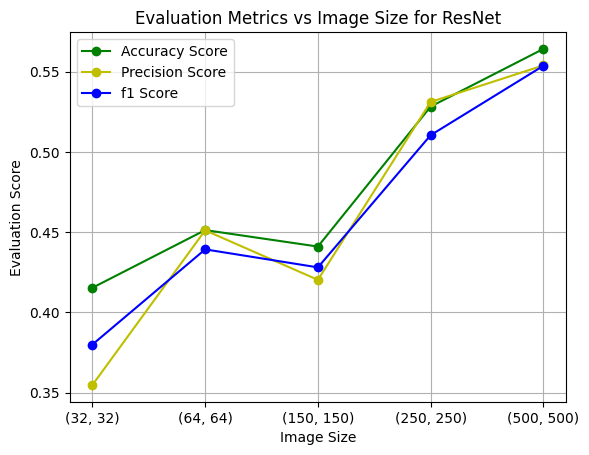

In [96]:
# Creating variables for each item in conv_accuracy_results
sizes, acc, prec, recall, f1, classrep = zip(*resNet_accuracy_results)

# Converting the image sizes into a string so they can be used for the X axis
sizes = [str(size) for size in sizes]

# Plot showing the Evaluation Metrics compared to Image size
plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
# Not using recall as it is identical to the accuracy rating when tested currently
#plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
plt.title('Evaluation Metrics vs Image Size for ResNet')
plt.xlabel('Image Size')
plt.ylabel('Evaluation Score')
plt.legend()
plt.grid()
plt.show()